In [1]:
import os
import sys
from google.colab import drive
drive.mount('/content/mnt')

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


In [0]:
nb_path = '/content/notebooks'
# os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)

In [0]:
# !pip install --target=$nb_path transformers

In [0]:
# Using pytorch tpu version
# VERSION = "20200325"
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [5]:
! pip install transformers emoji regex seaborn mecab-python3

In [6]:
# Using TPU
import torch
# import torch_xla
# import torch_xla.core.xla_model as xm

USE_TPU = False
if USE_TPU:
  device = xm.xla_device()
else: 
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("Device: {}".format(device))

Device: cuda:0


In [7]:
# Packages for neural network
import transformers
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# Basic function for other usages
import os
import time
import random
import warnings
import re
import emoji
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def seed_everything(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [9]:
df = pd.read_csv(r"https://raw.githubusercontent.com/penguinwang96825/Text_Classifier_for_UtaPass_and_KKBOX/master/data/all_20200423.csv", 
                 usecols=["content", "rating"])
df.head()

,rating,content
0,2,アプリをダウンロードしたばかりで、バックグラウンドで聴いています。星の理由は曲のダウンロード...
1,5,NaN
2,5,ダウンロードはネットが必要ですが、その後はオフラインで聞くことが出来てとても便利です。 オフ...
3,4,広告をあまり見たくない方は、下のタブにある本人→右上のアイコンを押すと、30秒間の広告を見る...
4,1,音楽をダウンロードしようと思ったら、ダウンロードマークが無くて、追加しかない状態だった。その...


In [0]:
def threshold_search(y_true, y_prob):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)]):
        score = f1_score(y_true=y_true, y_pred=y_prob > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

In [11]:
def give_emoji_free_text(text):
    allchars = [string for string in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    cleaned_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return cleaned_text

def clean_text(text):
    # Remove emoji
    text = give_emoji_free_text(text)
    # Remove punctuation
    text = re.sub(r'[^\w\d\s]+', '', text)
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    return text

df.dropna(inplace=True, axis=0)
df["content"] = df["content"].map(str)
df["content"] = df["content"].apply(clean_text)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13861 entries, 0 to 13922
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   rating   13861 non-null  int64 
 1   content  13861 non-null  object
dtypes: int64(1), object(1)
memory usage: 324.9+ KB


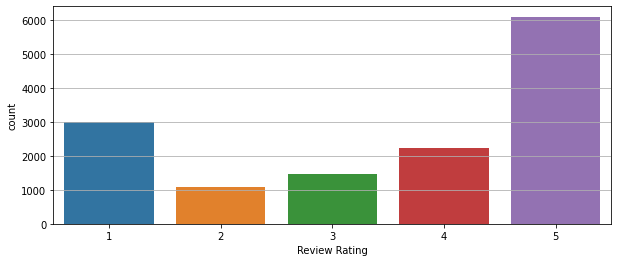

In [12]:
plt.figure(figsize=(10, 4))
sns.countplot(df.rating)
plt.xlabel("Review Rating")
plt.grid(axis="y")

In [13]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 3: return 0
    else: return 1
    
df["rating"] = df["rating"].apply(to_sentiment)
class_name = ["negative", "positive"]
df.head()

,rating,content
0,0,アプリをダウンロードしたばかりでバックグラウンドで聴いています星の理由は曲のダウンロードが出...
2,1,ダウンロードはネットが必要ですがその後はオフラインで聞くことが出来てとても便利です オフライ...
3,1,広告をあまり見たくない方は下のタブにある本人右上のアイコンを押すと秒間の広告を見る代わりに時...
4,0,音楽をダウンロードしようと思ったらダウンロードマークが無くて追加しかない状態だったその上どれ...
5,1,個人の感想ですが色々な曲が聞けて使いやすいしとても便利なアプリだと思います ですが歌詞が表示...


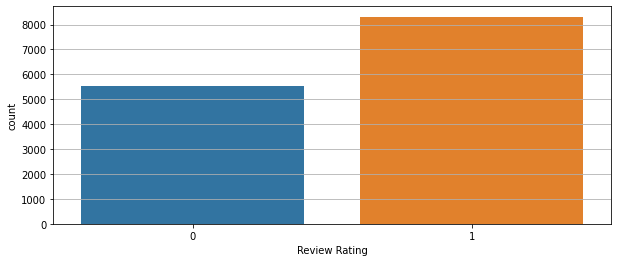

In [14]:
plt.figure(figsize=(10, 4))
sns.countplot(df.rating)
plt.xlabel("Review Rating")
plt.grid(axis="y")

In [0]:
# There is some other options:
# 1. bert-base-japanese
# 2. bert-base-japanese-whole-word-masking
# 3. bert-base-japanese-char
# 4. bert-base-japanese-char-whole-word-masking

PRE_TRAINED_MODEL_NAME = "bert-base-japanese"
tokenizer = BertJapaneseTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
sample_text = "ダウンロードはネットが必要ですが、その後はオフラインで聞くことが出来てとても便利です。"
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print("Sentence:   {}".format(sample_text))
print("Tokens:     {}".format(tokens))
print("Tokens IDs: {}".format(token_ids))

Sentence:   ダウンロードはネットが必要ですが、その後はオフラインで聞くことが出来てとても便利です。
Tokens:     ['ダウンロード', 'は', 'ネット', 'が', '必要', 'です', 'が', '、', 'その後', 'は', 'オフ', '##ライン', 'で', '聞く', 'こと', 'が', '出来', 'て', 'とても', '便利', 'です', '。']
Tokens IDs: [7852, 9, 1920, 14, 727, 2992, 14, 6, 366, 9, 4838, 2716, 12, 10317, 45, 14, 1380, 16, 8567, 15249, 2992, 8]


In [17]:
print("[CLS] ID: ", tokenizer.cls_token_id)
print("[SEP] ID: ", tokenizer.sep_token_id)
print("[PAD] ID: ", tokenizer.pad_token_id)
print("[UNK] ID: ", tokenizer.unk_token_id)

[CLS] ID:  2
[SEP] ID:  3
[PAD] ID:  0
[UNK] ID:  1


Text(0.5, 0, 'Sentence Length (after tokenized)')

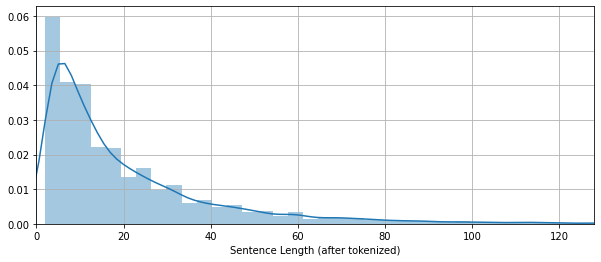

In [18]:
# Check tokenized sentence length in whole dataframe
tokens_length = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    tokens_length.append(len(tokens))
    
plt.figure(figsize=(10, 4))
sns.distplot(tokens_length)
plt.grid()
plt.xlim([0, 128])
plt.xlabel("Sentence Length (after tokenized)")

In [0]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
            review, 
            max_length=self.max_len, 
            add_special_tokens=True, 
            return_token_type_ids=False, 
            pad_to_max_length=True, 
            return_attention_mask=True, 
            return_tensors="pt")
        
        return {
            "review_text": review, 
            "input_ids": encoding["input_ids"].flatten(), 
            "attention_mask": encoding["attention_mask"].flatten(), 
            "target": torch.tensor(target, dtype=torch.long)
        }

def create_dataloader(df, tokenizer, max_len, batch_size):
    dataset = ReviewDataset(
        reviews=df.content.to_numpy(), 
        targets=df.rating.to_numpy(), 
        tokenizer=tokenizer, 
        max_len=max_len)
    
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0)

In [21]:
df_train, df_test = train_test_split(df, test_size=0.4, shuffle=True, random_state=17)
df_val, df_test = train_test_split(df_test, test_size=0.5, shuffle=False, random_state=17)

print("Train Size: ", df_train.shape)
print("Validation Size: ", df_val.shape)
print("Test Size: ", df_test.shape)

Train Size:  (8316, 2)
Validation Size:  (2772, 2)
Test Size:  (2773, 2)


In [0]:
BATCH_SIZE = 128
MAX_LEN = 64

train_dataloader = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = create_dataloader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [23]:
data = next(iter(train_dataloader))
print("Input IDs shape:         ", data['input_ids'].shape)
print("Attention mask shape:    ", data['attention_mask'].shape)
print("Label shape:             ", data['target'].shape)

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidden_state, pooled_output = bert_model(
    input_ids=data['input_ids'],
    attention_mask=data['attention_mask'])
print("Last hidden state shape: ", last_hidden_state.shape)
print("[CLS] token output shape:", pooled_output.shape)

Input IDs shape:          torch.Size([128, 64])
Attention mask shape:     torch.Size([128, 64])
Label shape:              torch.Size([128])
Last hidden state shape:  torch.Size([128, 64, 768])
[CLS] token output shape: torch.Size([128, 768])


In [0]:
class KKBOXSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(KKBOXSentimentClassifier, self).__init__()
        self.bert_layer = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.dropout = nn.Dropout(p=0.25)
        self.classifier = nn.Linear(self.bert_layer.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert_layer(
            input_ids=input_ids, 
            attention_mask=attention_mask)
        main = self.dropout(pooled_output)
        return F.softmax(self.classifier(main), dim=1)

In [25]:
class_name = ["Negative", "Positive"]
torch.cuda.empty_cache()
model = KKBOXSentimentClassifier(len(class_name))
model.to(device)

KKBOXSentimentClassifier(
  (bert_layer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [0]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps)
loss_function = nn.CrossEntropyLoss().to(device)

In [0]:
def train_bert(model, data_loader, loss_function, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    
    for data in data_loader:
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        targets = data["target"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs, targets)
        
        for p, t in zip(preds, targets):
            if p == 1 and t == 1:
                true_pos += 1
            if p == 0 and t == 0:
                true_neg += 1
            if p == 1 and t == 0:
                false_pos += 1
            if p == 0 and t == 1:
                false_neg += 1
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    recall = true_pos / float(true_pos + false_neg)
    precision = true_pos / float(true_pos + false_pos)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / float(n_examples)
        
    return accuracy, f1, np.mean(losses)

In [0]:
def eval_bert(model, data_loader, loss_function, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["target"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
            for p, t in zip(preds, targets):
                if p == 1 and t == 1:
                    true_pos += 1
                if p == 0 and t == 0:
                    true_neg += 1
                if p == 1 and t == 0:
                    false_pos += 1
                if p == 0 and t == 1:
                    false_neg += 1
                    
    recall = true_pos / float(true_pos + false_neg)
    precision = true_pos / float(true_pos + false_pos)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / float(n_examples)

    return accuracy, f1, np.mean(losses)

In [29]:
%%time

history = defaultdict(list)
best_f1 = 0
path = r"/content/mnt/My Drive/notebooks/BERT/checkpoints/best_bert_japanese_whole_masking.bin"

for epoch in range(EPOCHS):
    start = time.time()
    print("="*10, "Epoch {}/{}".format(epoch+1, EPOCHS), "="*10)
    
    train_acc, train_f1, train_loss = train_bert(
        model, train_dataloader, loss_function, optimizer, device, scheduler, len(df_train))
    
    print("Train: ")
    print("  Loss: {:.4f} | Accuracy: {:.4f} | F1: {:.4f}".format(train_loss, train_acc, train_f1))
    # print("Train loss: {}".format(train_loss))
    # print("Train accuracy: {}".format(train_acc))
    # print("Train f1: {}\n".format(train_f1))
    
    val_acc, val_f1, val_loss = eval_bert(
        model, val_dataloader, loss_function, device, len(df_val))
    
    print("Validation: ")
    print("  Loss: {:.4f} | Accuracy: {:.4f} | F1: {:.4f}".format(val_loss, val_acc, val_f1))
    # print("Validation loss: {}".format(val_loss))
    # print("Validation accuracy: {}".format(val_acc))
    # print("Validation f1: {}\n".format(val_f1))
    
    history["train_f1"].append(train_f1)
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_f1"].append(val_f1)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)
    
    print("\nElapsed time: {:.2f}s\n".format(time.time()-start))
    
    if val_f1 > best_f1:
        torch.save(model.state_dict(), path)
        best_f1 = val_f1

========== Epoch 1/4 ==========
Train: 
  Loss: 0.5059 | Accuracy: 0.7969 | F1: 0.8354
Validation: 
  Loss: 0.4738 | Accuracy: 0.8355 | F1: 0.8700

Elapsed time: 172.56s

========== Epoch 2/4 ==========
Train: 
  Loss: 0.4425 | Accuracy: 0.8664 | F1: 0.8898
Validation: 
  Loss: 0.4579 | Accuracy: 0.8492 | F1: 0.8741

Elapsed time: 173.23s

========== Epoch 3/4 ==========
Train: 
  Loss: 0.4206 | Accuracy: 0.8902 | F1: 0.9095
Validation: 
  Loss: 0.4619 | Accuracy: 0.8474 | F1: 0.8761

Elapsed time: 173.35s

========== Epoch 4/4 ==========
Train: 
  Loss: 0.4082 | Accuracy: 0.9032 | F1: 0.9204
Validation: 
  Loss: 0.4584 | Accuracy: 0.8517 | F1: 0.8785

Elapsed time: 173.31s

CPU times: user 7min 4s, sys: 4min 28s, total: 11min 33s
Wall time: 11min 39s


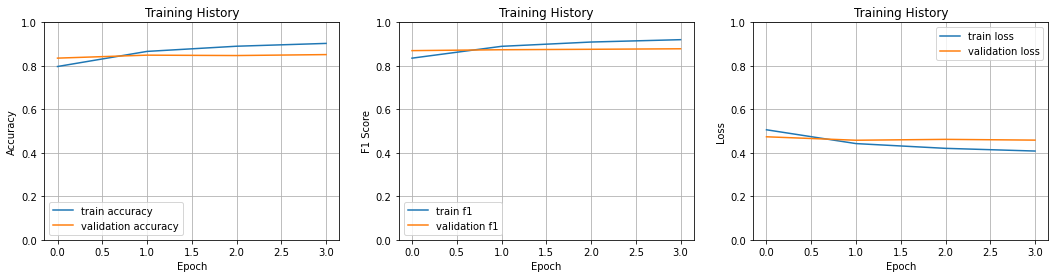

In [30]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(history["train_acc"], label="train accuracy")
plt.plot(history["val_acc"], label="validation accuracy")
plt.title("Training History")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.ylim([0, 1])
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(history["train_f1"], label="train f1")
plt.plot(history["val_f1"], label="validation f1")
plt.title("Training History")
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.ylim([0, 1])
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="validation loss")
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim([0, 1])
plt.legend()
plt.grid()

In [31]:
start = time.time()
test_acc, test_f1, _ = eval_bert(
    model, test_dataloader, loss_function, device, len(df_test))
print("Test set accuracy: {:.4f}".format(test_acc))
print("Test set f1 score: {:.4f}".format(test_f1))
print("\nElapsed time: {:.2f}s".format(time.time()-start))

Test set accuracy: 0.8622
Test set f1 score: 0.8897

Elapsed time: 20.37s


In [0]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
    plt.figure(figsize=(10, 8))
    hmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha="right")
    plt.xlabel("Predicted Sentiment")
    plt.ylabel("Target Sentiment")
    plt.show()

In [0]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    reviews_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for data in data_loader:
            texts = data["review_text"]
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["target"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            reviews_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return reviews_texts, predictions, prediction_probs, real_values

              precision    recall  f1-score   support

    Negative       0.85      0.78      0.82      1086
    Positive       0.87      0.91      0.89      1687

    accuracy                           0.86      2773
   macro avg       0.86      0.85      0.85      2773
weighted avg       0.86      0.86      0.86      2773



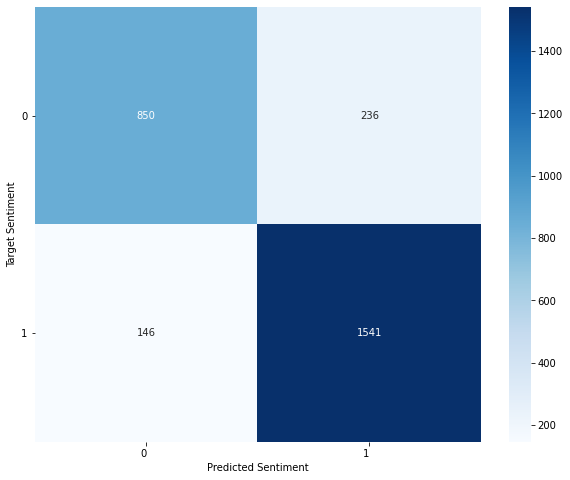

In [34]:
y_reviews_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_dataloader)
print(classification_report(y_test, y_pred, target_names=class_name, zero_division=0))
plot_confusion_matrix(y_test, y_pred)

In [35]:
def predict(text, model, tokenizer):
  text = clean_text(text)
  encoding = tokenizer.encode_plus(
      text, 
      max_length=MAX_LEN, 
      add_special_tokens=True, 
      return_token_type_ids=False, 
      pad_to_max_length=True, 
      return_attention_mask=True, 
      return_tensors="pt")
  input_ids = encoding["input_ids"].to(device)
  attention_mask = encoding["attention_mask"].to(device)
  with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits, preds = torch.max(outputs, dim=1)
  # outputs = outputs.to("cpu").tolist()[0]
  return logits.to("cpu").tolist()[0], class_name[preds.to("cpu")]

sample_text = "急にログインできない。いろいろ試したがログインはやはりできない。"
logit, pred = predict(sample_text, model, tokenizer)
print("Tokenized text:        {}".format(tokenizer.tokenize(sample_text)))
print("Predicted sentiment:   {}".format(pred))
print("Predicted probability: {:.4f}".format(logit))

Tokenized text:        ['急', 'に', 'ログ', '##イン', 'でき', 'ない', '。', 'いろいろ', '試し', 'た', 'が', 'ログ', '##イン', 'は', 'やはり', 'でき', 'ない', '。']
Predicted sentiment:   Negative
Predicted probability: 0.9998


In [0]:
torch.save(model, "/content/mnt/My Drive/notebooks/BERT/checkpoints/best_bert_japanese.pkl")